In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")


In [23]:
import yfinance as yf
import pandas as pd
# Definir los símbolos de los índices
BBVA_ticker = "BBVA.MC" # S&P 500
BANCO_SANTANDER_ticker = "SAN.MC" # IBEX 35
# Definir el rango de fechas
start_date = "2000-01-01"
end_date = "2024-01-01"
# Descargar los datos históricos desde Yahoo Finance
BBVA_data = yf.download(BBVA_ticker, start=start_date, end=end_date)
SANTANDER_data = yf.download(BANCO_SANTANDER_ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [24]:
# Mostrar las primeras filas de cada dataset
print("BBVA 500 Data:")
print(BBVA_data.head())
print("\nSantander 35 Data:")
print(SANTANDER_data.head())
# Guardar los datos en CSV (opcional)
BBVA_data.to_csv("bbva.csv")
SANTANDER_data.to_csv("satander.csv")

BBVA 500 Data:
Price          Close      High       Low      Open    Volume
Ticker       BBVA.MC   BBVA.MC   BBVA.MC   BBVA.MC   BBVA.MC
Date                                                        
2000-01-03  4.115110  4.155739  4.106404  4.135425   8244257
2000-01-04  4.007734  4.088991  3.993224  4.062873   8522096
2000-01-05  3.917773  3.990324  3.900361  3.970010  12159826
2000-01-06  3.917773  3.917773  3.917773  3.917773         0
2000-01-07  3.967106  4.001930  3.926477  4.001930  62261944

Santander 35 Data:
Price          Close      High       Low      Open   Volume
Ticker        SAN.MC    SAN.MC    SAN.MC    SAN.MC   SAN.MC
Date                                                       
2000-01-03  2.659120  2.696506  2.628743  2.687160  8797337
2000-01-04  2.596029  2.640426  2.572663  2.626406  8811013
2000-01-05  2.532940  2.579673  2.511910  2.546959  9333517
2000-01-06  2.532940  2.532940  2.532940  2.532940        0
2000-01-07  2.645100  2.652110  2.549297  2.551634  96031

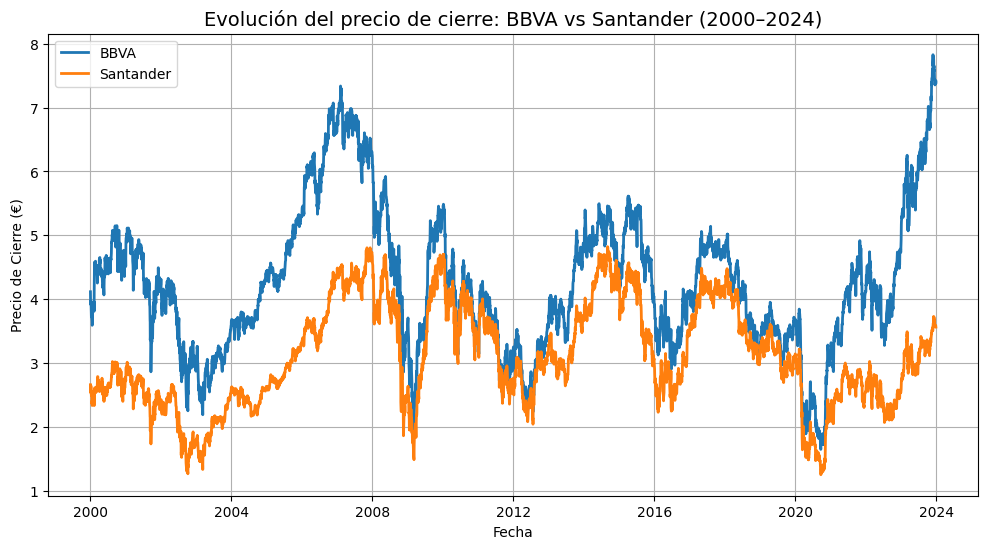

In [25]:
import matplotlib.pyplot as plt

# Seleccionar las columnas de cierre
bbva_close = BBVA_data['Close']
santander_close = SANTANDER_data['Close']

# Crear la figura
plt.figure(figsize=(12,6))

# Dibujar ambas curvas
plt.plot(bbva_close, label='BBVA', linewidth=2)
plt.plot(santander_close, label='Santander', linewidth=2)

# Añadir título y etiquetas
plt.title('Evolución del precio de cierre: BBVA vs Santander (2000–2024)', fontsize=14)
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre (€)')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()


### Carga desde CSV y limpieza de datos

In [26]:
import pandas as pd
import numpy as np

# --- CARGA DE DATOS CORREGIDA ---
# Saltamos las 3 primeras filas del CSV
bbva = pd.read_csv("bbva.csv", skiprows=3)
santander = pd.read_csv("satander.csv", skiprows=3)

# Renombrar columnas (porque la cabecera original se perdió)
bbva.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
santander.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

# Convertir 'Date' a datetime y ponerla como índice
bbva['Date'] = pd.to_datetime(bbva['Date'])
santander['Date'] = pd.to_datetime(santander['Date'])
bbva.set_index('Date', inplace=True)
santander.set_index('Date', inplace=True)

# Asegurar tipos numéricos
bbva = bbva.apply(pd.to_numeric, errors='coerce')
santander = santander.apply(pd.to_numeric, errors='coerce')

# Limpiar valores nulos
bbva.dropna(inplace=True)
santander.dropna(inplace=True)

# Control
print("✅ Columnas BBVA:", bbva.columns.tolist())
print("✅ Columnas Santander:", santander.columns.tolist())
print(bbva.head(3))
print(santander.head(3))


✅ Columnas BBVA: ['Open', 'High', 'Low', 'Close', 'Volume']
✅ Columnas Santander: ['Open', 'High', 'Low', 'Close', 'Volume']
                Open      High       Low     Close    Volume
Date                                                        
2000-01-04  4.007734  4.088991  3.993224  4.062873   8522096
2000-01-05  3.917773  3.990324  3.900361  3.970010  12159826
2000-01-06  3.917773  3.917773  3.917773  3.917773         0
                Open      High       Low     Close   Volume
Date                                                       
2000-01-04  2.596029  2.640426  2.572663  2.626406  8811013
2000-01-05  2.532940  2.579673  2.511910  2.546959  9333517
2000-01-06  2.532940  2.532940  2.532940  2.532940        0


### Análisis exploratorio y descomposición de series temporales

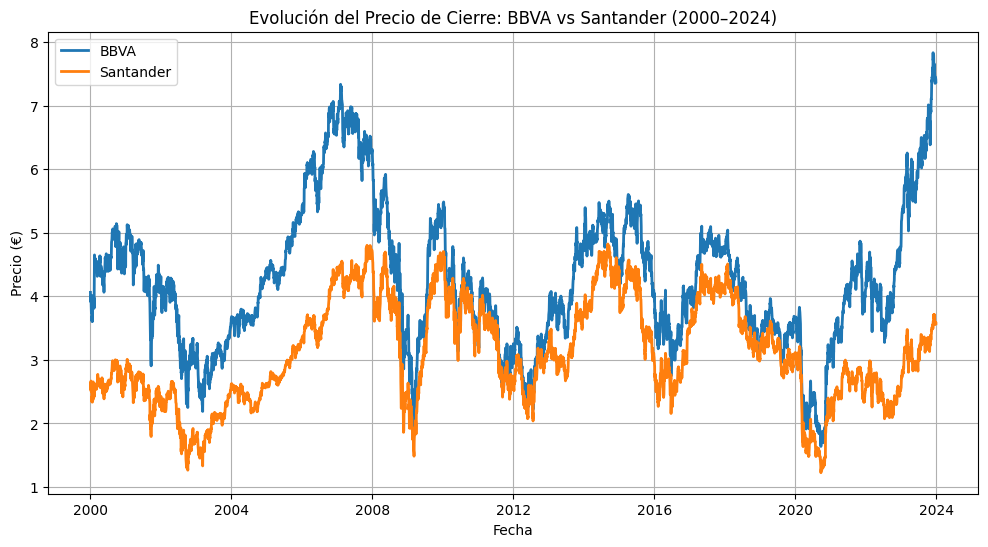

Resumen BBVA:
               Open         High          Low        Close        Volume
count  6164.000000  6164.000000  6164.000000  6164.000000  6.164000e+03
mean      4.250801     4.301335     4.195522     4.250693  3.941927e+07
std       1.114663     1.114787     1.112904     1.113242  3.928296e+07
min       1.646662     1.696977     1.622267     1.639039  0.000000e+00
25%       3.470130     3.520337     3.421935     3.475692  1.798585e+07
50%       4.129217     4.189264     4.081217     4.138752  2.852135e+07
75%       4.868101     4.915245     4.814364     4.867382  4.669235e+07
max       7.827237     7.854239     7.735427     7.834438  6.009019e+08

Resumen Santander:
               Open         High          Low        Close        Volume
count  6164.000000  6164.000000  6164.000000  6164.000000  6.164000e+03
mean      3.100294     3.138968     3.058922     3.101175  7.647724e+07
std       0.800758     0.803426     0.796625     0.800609  6.692051e+07
min       1.249884     1.274

In [27]:
plt.figure(figsize=(12,6))
plt.plot(bbva['Close'], label='BBVA', linewidth=2)
plt.plot(santander['Close'], label='Santander', linewidth=2)
plt.title('Evolución del Precio de Cierre: BBVA vs Santander (2000–2024)')
plt.xlabel('Fecha')
plt.ylabel('Precio (€)')
plt.legend()
plt.grid(True)
plt.show()

print("Resumen BBVA:\n", bbva.describe())
print("\nResumen Santander:\n", santander.describe())


### Descomposición estacional (tendencia, ciclo, residuo)

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt


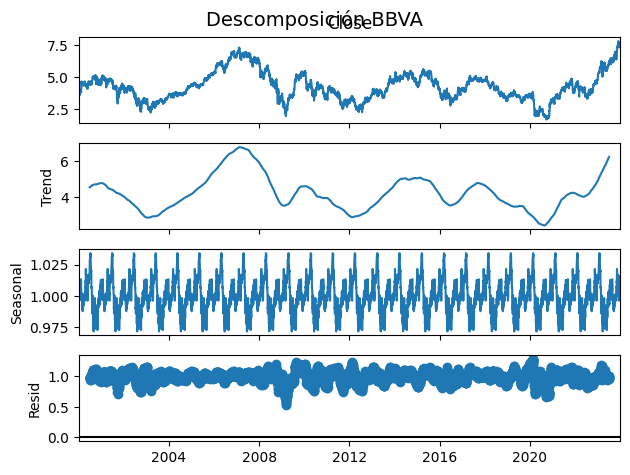

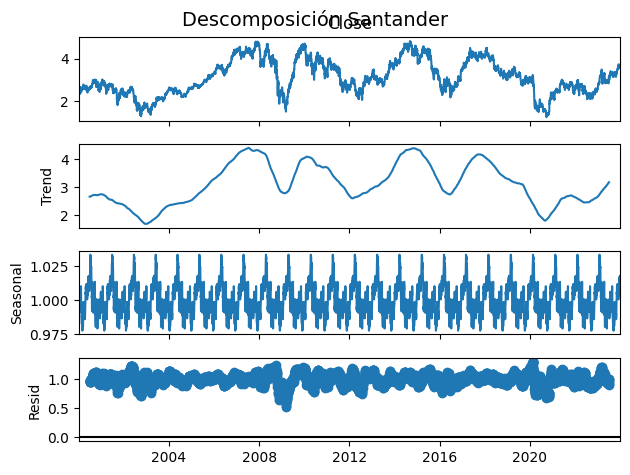

In [29]:
result_bbva = seasonal_decompose(bbva['Close'], model='multiplicative', period=252)
result_san = seasonal_decompose(santander['Close'], model='multiplicative', period=252)

result_bbva.plot()
plt.suptitle("Descomposición BBVA", fontsize=14)
plt.show()

result_san.plot()
plt.suptitle("Descomposición Santander", fontsize=14)
plt.show()


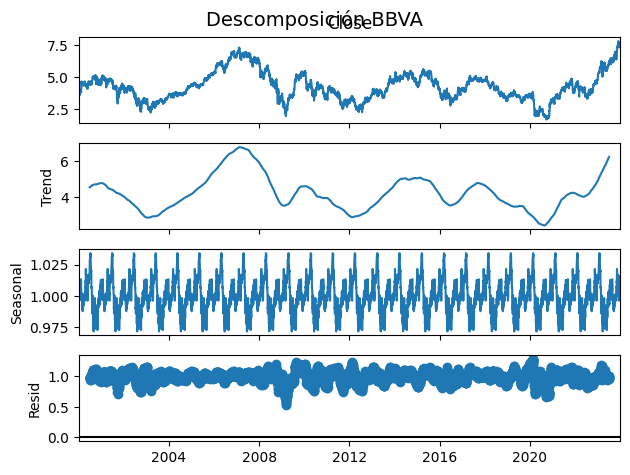

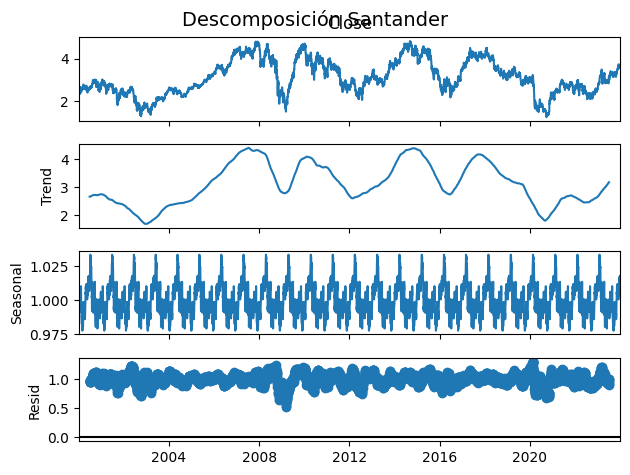

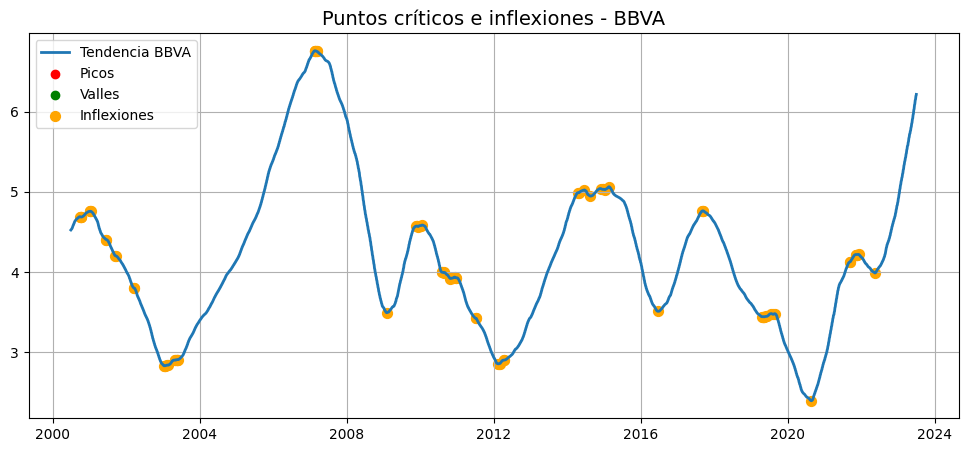

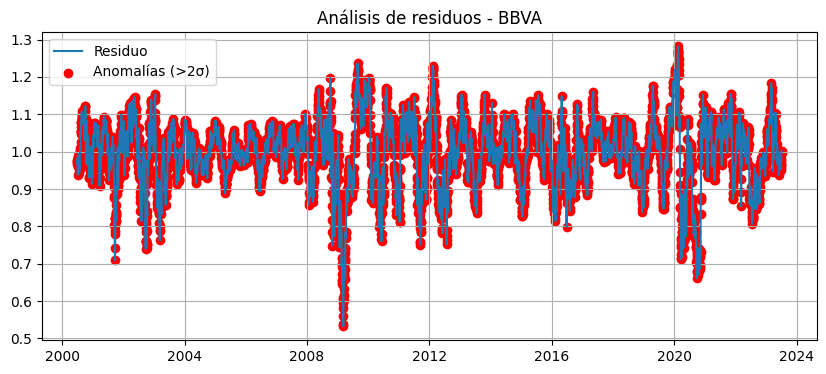


===== BBVA =====
Total de picos detectados: 44
Total de valles detectados: 44
Total de puntos de inflexión: 88
Total de anomalías residuales: 5912



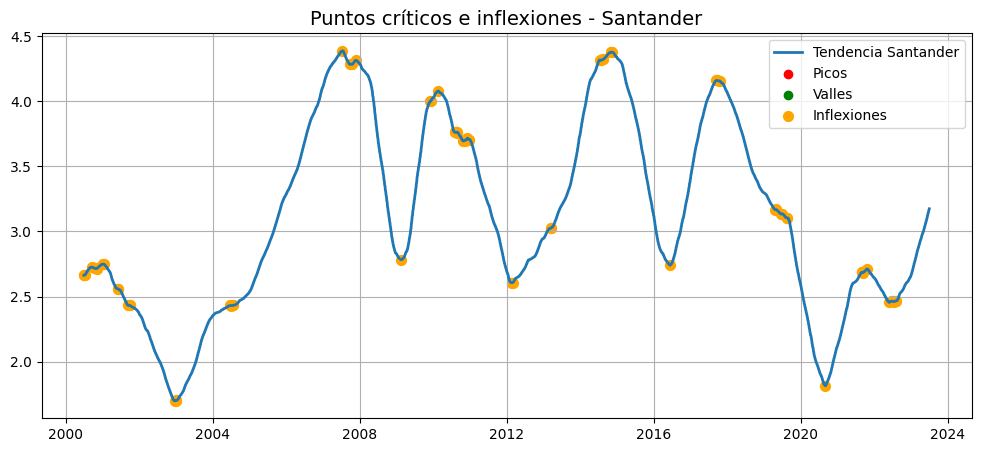

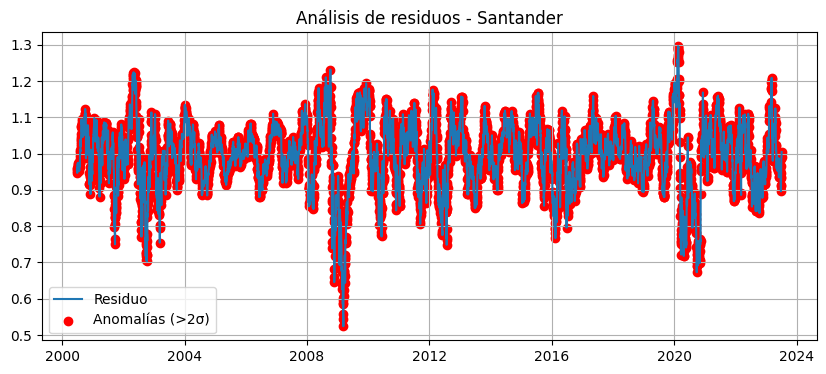


===== SANTANDER =====
Total de picos detectados: 41
Total de valles detectados: 42
Total de puntos de inflexión: 83
Total de anomalías residuales: 5912



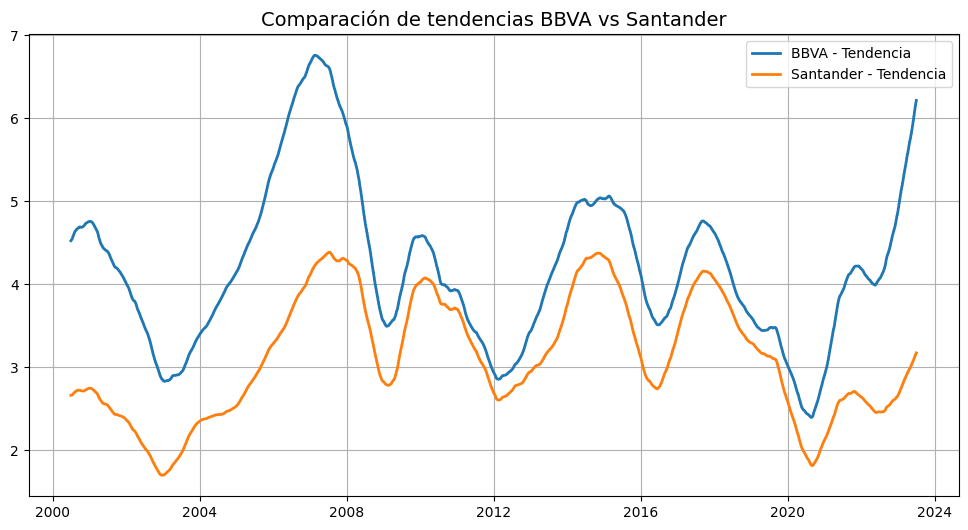

In [30]:
# ============================================
# 🔍 ANÁLISIS DE SERIES TEMPORALES BBVA Y SANTANDER
# Descomposición + puntos críticos + anomalías
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from statsmodels.tsa.seasonal import seasonal_decompose

# --- 1. DESCOMPOSICIÓN DE LA SERIE ---
periodo = 252  # días bursátiles por año
result_bbva = seasonal_decompose(bbva['Close'], model='multiplicative', period=periodo)
result_san = seasonal_decompose(santander['Close'], model='multiplicative', period=periodo)

# Visualización
result_bbva.plot()
plt.suptitle("Descomposición BBVA", fontsize=14)
plt.show()

result_san.plot()
plt.suptitle("Descomposición Santander", fontsize=14)
plt.show()


# --- 2. FUNCIÓN AUXILIAR PARA ANÁLISIS DE TENDENCIA ---
def analizar_tendencia(result, nombre):
    trend = result.trend.dropna()
    resid = result.resid.dropna()

    # 2.1. Puntos de inflexión (cambio de signo en la derivada)
    dif = trend.diff()
    inflection_points = trend[(dif.shift(-1) * dif) < 0]

    # 2.2. Picos y valles (máximos y mínimos locales)
    indices_max = argrelextrema(trend.values, np.greater)[0]
    indices_min = argrelextrema(trend.values, np.less)[0]
    picos = trend.iloc[indices_max]
    valles = trend.iloc[indices_min]

    # 2.3. Análisis de residuos (anomalías > 2σ)
    outliers = resid[abs(resid) > 2 * resid.std()]

    # --- Visualización ---
    plt.figure(figsize=(12, 5))
    plt.plot(trend, label=f'Tendencia {nombre}', linewidth=2)
    plt.scatter(picos.index, picos.values, color='red', label='Picos')
    plt.scatter(valles.index, valles.values, color='green', label='Valles')
    plt.scatter(inflection_points.index, inflection_points.values, color='orange', label='Inflexiones', s=50)
    plt.title(f"Puntos críticos e inflexiones - {nombre}", fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Gráfico de residuos ---
    plt.figure(figsize=(10, 4))
    plt.plot(resid, label='Residuo')
    plt.scatter(outliers.index, outliers.values, color='red', label='Anomalías (>2σ)')
    plt.title(f"Análisis de residuos - {nombre}", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Resumen numérico ---
    print(f"\n===== {nombre.upper()} =====")
    print(f"Total de picos detectados: {len(picos)}")
    print(f"Total de valles detectados: {len(valles)}")
    print(f"Total de puntos de inflexión: {len(inflection_points)}")
    print(f"Total de anomalías residuales: {len(outliers)}\n")

    return {
        "trend": trend,
        "picos": picos,
        "valles": valles,
        "inflection_points": inflection_points,
        "outliers": outliers
    }


# --- 3. EJECUCIÓN DEL ANÁLISIS PARA CADA SERIE ---
resultados_bbva = analizar_tendencia(result_bbva, "BBVA")
resultados_san = analizar_tendencia(result_san, "Santander")


# --- 4. COMPARACIÓN DE TENDENCIAS ENTRE BBVA Y SANTANDER ---
plt.figure(figsize=(12, 6))
plt.plot(resultados_bbva['trend'], label='BBVA - Tendencia', linewidth=2)
plt.plot(resultados_san['trend'], label='Santander - Tendencia', linewidth=2)
plt.title("Comparación de tendencias BBVA vs Santander", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


### Normalización y creación de secuencias (ventanas temporales)

Cambios:
lookbak 100

In [31]:
scaler = MinMaxScaler(feature_range=(0, 1))

def preparar_datos(df, columna='Close', lookback=60):
    data_scaled = scaler.fit_transform(df[[columna]])
    X, y = [], []
    for i in range(lookback, len(data_scaled)):
        X.append(data_scaled[i-lookback:i, 0])
        y.append(data_scaled[i, 0])
    X, y = np.array(X), np.array(y)
    return X, y, data_scaled

lookback = 100
X_bbva, y_bbva, scaled_bbva = preparar_datos(bbva)
X_san, y_san, scaled_san = preparar_datos(santander)

# Reshape para RNNs
X_bbva = X_bbva.reshape((X_bbva.shape[0], X_bbva.shape[1], 1))
X_san = X_san.reshape((X_san.shape[0], X_san.shape[1], 1))

print("Forma BBVA:", X_bbva.shape, y_bbva.shape)
print("Forma SAN:", X_san.shape, y_san.shape)


Forma BBVA: (6104, 60, 1) (6104,)
Forma SAN: (6104, 60, 1) (6104,)


### División entrenamiento / test

In [32]:
train_size = int(len(X_bbva) * 0.8)

X_train_bbva, X_test_bbva = X_bbva[:train_size], X_bbva[train_size:]
y_train_bbva, y_test_bbva = y_bbva[:train_size], y_bbva[train_size:]

X_train_san, X_test_san = X_san[:train_size], X_san[train_size:]
y_train_san, y_test_san = y_san[:train_size], y_san[train_size:]


### Entrenamiento y comparación de modelos RNN, LSTM y GRU

In [34]:
def entrenar_modelo(X_train, y_train, X_test, y_test, tipo='LSTM', epochs=20):
    model = Sequential()
    if tipo == 'SimpleRNN':
        model.add(SimpleRNN(80, return_sequences=False, input_shape=(X_train.shape[1], 1)))
    elif tipo == 'LSTM':
        model.add(LSTM(80, return_sequences=False, input_shape=(X_train.shape[1], 1)))
    elif tipo == 'GRU':
        model.add(GRU(80, return_sequences=False, input_shape=(X_train.shape[1], 1)))
    
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=epochs, batch_size=32, verbose=1, callbacks=[es])
    return model, history

# Entrenamos uno de cada tipo (solo BBVA para ejemplo)
model_rnn, _ = entrenar_modelo(X_train_bbva, y_train_bbva, X_test_bbva, y_test_bbva, tipo='SimpleRNN')
model_lstm, _ = entrenar_modelo(X_train_bbva, y_train_bbva, X_test_bbva, y_test_bbva, tipo='LSTM')
model_gru, _ = entrenar_modelo(X_train_bbva, y_train_bbva, X_test_bbva, y_test_bbva, tipo='GRU') 


Epoch 1/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0010 - val_loss: 3.7310e-04
Epoch 2/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.3070e-04 - val_loss: 2.7812e-04
Epoch 3/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.7171e-04 - val_loss: 2.5029e-04
Epoch 4/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.5137e-04 - val_loss: 2.7584e-04
Epoch 5/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2520e-04 - val_loss: 3.3881e-04
Epoch 6/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.1883e-04 - val_loss: 2.2347e-04
Epoch 7/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.0589e-04 - val_loss: 2.2575e-04
Epoch 8/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.1811e-04 - val_loss: 2.0490e-04
Epoch 9/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.0153e-04 - val_loss: 2.9038e-04
Epoch 10/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.9996e-04 - val_loss: 2.0661e-04
Epoch 11/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.

In [37]:
def entrenar_modelo(X_train, y_train, X_test, y_test, tipo='LSTM', epochs=20):
    model = Sequential()
    if tipo == 'SimpleRNN':
        model.add(SimpleRNN(50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
    elif tipo == 'LSTM':
        model.add(LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
    elif tipo == 'GRU':
        model.add(GRU(50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
    
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=epochs, batch_size=32, verbose=1, callbacks=[es])
    return model, history

# Entrenamos uno de cada tipo (solo BBVA para ejemplo)
model_rnn, _ = entrenar_modelo(X_train_bbva, y_train_bbva, X_test_bbva, y_test_bbva, tipo='SimpleRNN')
model_lstm, _ = entrenar_modelo(X_train_bbva, y_train_bbva, X_test_bbva, y_test_bbva, tipo='LSTM')
model_gru, _ = entrenar_modelo(X_train_bbva, y_train_bbva, X_test_bbva, y_test_bbva, tipo='GRU') 


Epoch 1/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0020 - val_loss: 5.3220e-04
Epoch 2/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.8067e-04 - val_loss: 3.6504e-04
Epoch 3/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.2710e-04 - val_loss: 4.1105e-04
Epoch 4/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.0929e-04 - val_loss: 3.5837e-04
Epoch 5/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.4532e-04 - val_loss: 3.1272e-04
Epoch 6/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.7245e-04 - val_loss: 2.7099e-04
Epoch 7/20
122/153 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4709e-04

KeyboardInterrupt: 

### Evaluación y comparación de resultados

In [38]:
def evaluar(modelo, X_test, y_test, nombre):
    pred = modelo.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, pred))
    mae = mean_absolute_error(y_test, pred)
    print(f"{nombre}: RMSE={rmse:.5f}, MAE={mae:.5f}")
    return pred

pred_rnn = evaluar(model_rnn, X_test_bbva, y_test_bbva, "SimpleRNN")
pred_lstm = evaluar(model_lstm, X_test_bbva, y_test_bbva, "LSTM")
pred_gru = evaluar(model_gru, X_test_bbva, y_test_bbva, "GRU")


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
SimpleRNN: RMSE=0.01431, MAE=0.01036
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
LSTM: RMSE=0.01626, MAE=0.01200
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
GRU: RMSE=0.01406, MAE=0.01025


### Visualización de predicciones

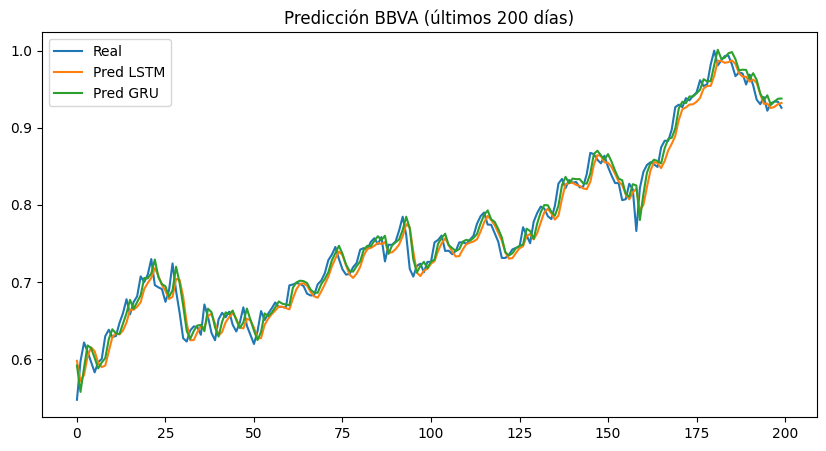

In [39]:
plt.figure(figsize=(10,5))
plt.plot(y_test_bbva[-200:], label="Real")
plt.plot(pred_lstm[-200:], label="Pred LSTM")
plt.plot(pred_gru[-200:], label="Pred GRU")
plt.title("Predicción BBVA (últimos 200 días)")
plt.legend()
plt.show()


### Predicción futura (forecast corto plazo)

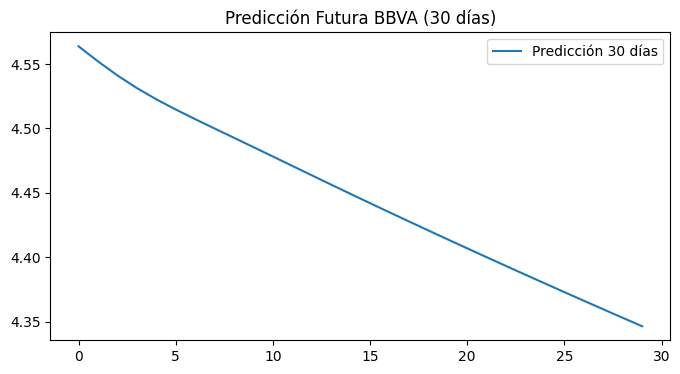

In [40]:
ultimos = scaled_bbva[-60:]
pred_future = []

modelo_final = model_lstm  # el mejor
for _ in range(30):  # predicción 30 días hacia adelante
    X_input = ultimos[-60:].reshape(1, 60, 1)
    y_pred = modelo_final.predict(X_input, verbose=0)
    pred_future.append(y_pred[0,0])
    ultimos = np.append(ultimos, y_pred)[-60:]

# Desescalar
pred_future_inv = scaler.inverse_transform(np.array(pred_future).reshape(-1,1))

plt.figure(figsize=(8,4))
plt.plot(pred_future_inv, label='Predicción 30 días')
plt.title("Predicción Futura BBVA (30 días)")
plt.legend()
plt.show()


### Graficar las predicciones futuras junto con el histórico

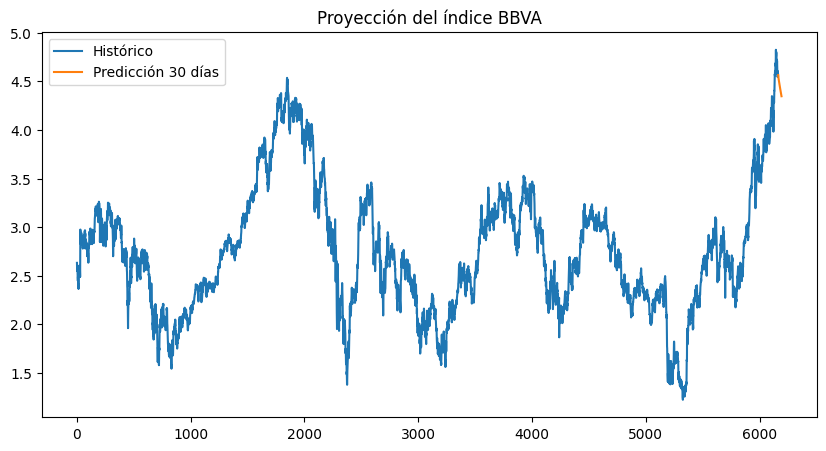

In [41]:
historial_real = scaler.inverse_transform(scaled_bbva)
plt.figure(figsize=(10,5))
plt.plot(range(len(historial_real)), historial_real, label='Histórico')
plt.plot(range(len(historial_real), len(historial_real)+30), pred_future_inv, label='Predicción 30 días')
plt.title("Proyección del índice BBVA")
plt.legend()
plt.show()


### Predicciones a corto y medio plazo 

In [42]:
ultimos = scaled_bbva[-60:]
pred_corto = []
pred_mediano = []

# Predicción corto plazo (10 días)
for _ in range(10):
    X_input = ultimos[-60:].reshape(1, 60, 1)
    y_pred = modelo_final.predict(X_input, verbose=0)
    pred_corto.append(y_pred[0,0])
    ultimos = np.append(ultimos, y_pred)[-60:]

# Guardamos el estado actual de ultimos para mediano plazo
ultimos_mediano = np.append(scaled_bbva[-60:], pred_corto)

# Predicción mediano plazo (30 días)
for _ in range(30):
    X_input = ultimos_mediano[-60:].reshape(1, 60, 1)
    y_pred = modelo_final.predict(X_input, verbose=0)
    pred_mediano.append(y_pred[0,0])
    ultimos_mediano = np.append(ultimos_mediano, y_pred)[-60:]

# Desescalamos
pred_corto_inv = scaler.inverse_transform(np.array(pred_corto).reshape(-1,1))
pred_mediano_inv = scaler.inverse_transform(np.array(pred_mediano).reshape(-1,1))


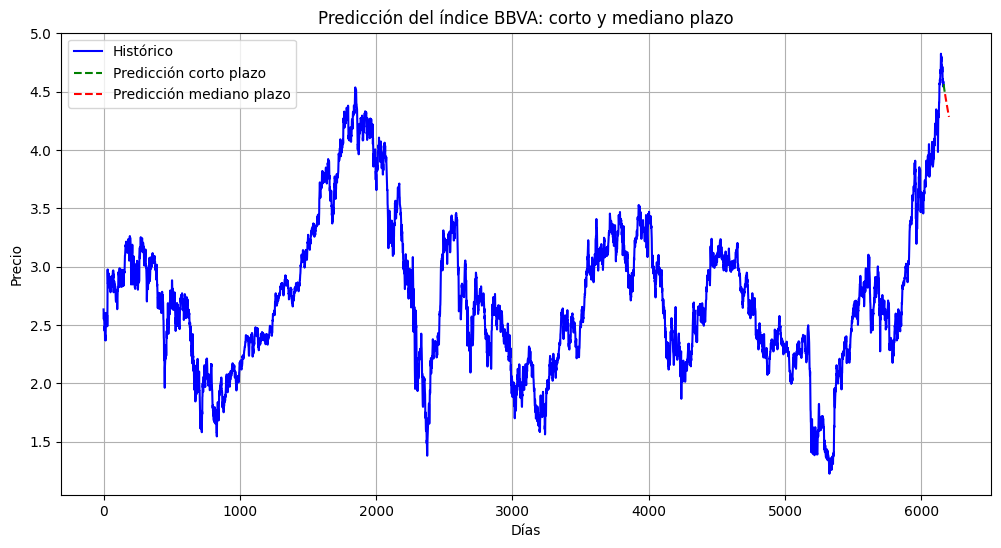

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Suponiendo que ya tienes:
# historial_real = scaler.inverse_transform(scaled_bbva)
# pred_corto_inv = predicción corto plazo (10 días)
# pred_mediano_inv = predicción mediano plazo (30 días)

# Creamos el eje de tiempo
t_hist = np.arange(len(historial_real))
t_corto = np.arange(len(historial_real), len(historial_real) + len(pred_corto_inv))
t_mediano = np.arange(len(historial_real) + len(pred_corto_inv), 
                      len(historial_real) + len(pred_corto_inv) + len(pred_mediano_inv))

plt.figure(figsize=(12,6))

# Histórico
plt.plot(t_hist, historial_real, label='Histórico', color='blue')

# Predicción corto plazo
plt.plot(t_corto, pred_corto_inv, label='Predicción corto plazo', color='green', linestyle='--')

# Predicción mediano plazo
plt.plot(t_mediano, pred_mediano_inv, label='Predicción mediano plazo', color='red', linestyle='--')

plt.title("Predicción del índice BBVA: corto y mediano plazo")
plt.xlabel("Días")
plt.ylabel("Precio")
plt.legend()
plt.grid(True)
plt.show()
